<a href="https://colab.research.google.com/github/FredDsR/TrabalhoFinal_ML/blob/main/TECIX_TrabalhoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementação de um classificador de tendência à pensamentos suicidas sobre dados da OMS

---


## Introdução
Neste notebook se encontra a implementação da etapa de transformação dos dados e a implementação de 3 (três) modelos de aprendizado de máquina supervisionado para predição de trendência ao pensamento suicida em jovens. Os modelos implementados foram *K-Nearest Neighbors (KNN)*, *Support-vector Machine (SVM)* e *Extreme Gradient Boosting (XGBoost)*.

### Aquisição dos dados

Os dados utilizados nesta implementação foram retirados do estudo Global School-Based Student Health Survey ralizado na Argentina em 2018. Maiores descrições e acesso aos dados estão disponíveis [aqui](https://extranet.who.int/ncdsmicrodata/index.php/catalog/866/study-description).

---

### Download e atualização de libs

In [ ]:
!wget -O /content/data.csv https://extranet.who.int/ncdsmicrodata/index.php/catalog/866/download/6149

!pip install scikit-learn --upgrade
!pip install xgboost --upgrade

--2021-11-08 13:59:07--  https://extranet.who.int/ncdsmicrodata/index.php/catalog/866/download/6149
Resolving extranet.who.int (extranet.who.int)... 158.232.12.136
Connecting to extranet.who.int (extranet.who.int)|158.232.12.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14705501 (14M) [application/octet-stream]
Saving to: ‘/content/data.csv’

/content/data.csv   100%[===================>]  14.02M  3.68MB/s    in 3.8s    

2021-11-08 13:59:12 (3.68 MB/s) - ‘/content/data.csv’ saved [14705501/14705501]

  Using cached xgboost-1.5.0-py3-none-manylinux2014_x86_64.whl (173.5 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


---

### Bibliotecas e ferramentas utilizadas

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

---

### Leitura

In [ ]:
data_df = pd.read_csv('/content/data.csv')

data_df.head()

,site,record,q1,q2,q3,q4,q5,q6,q10,q15,q16,q17,q18,q19,q22,q23,q24,q25,q26,q27,q28,q29,q30,q31,q32,q33,q34,q35,q36,q37,q38,q39,q40,q41,q42,q43,q44,q45,q46,q47,...,qn42,qn43,qn44,qn45,qn46,qn47,qn48,qn49,qn50,qn51,qn52,qn53,qn54,qn55,qn56,qn57,qn58,qn61,qn62,qn63,qn66,qn67,qn68,qnunwtg,qnowtg,qnobeseg,qnff1g,qnff2g,qnff3g,qntob2g,qnnotb2g,qnbcanyg,qnc1g,qnpa5g,qnpa7g,qnpe3g,qnpe5g,weight,stratum,psu
0,AG,1,3.0,2.0,2.0,NaN,NaN,2.0,1.0,1.0,1.0,1.0,1.0,NaN,5.0,5.0,1.0,2.0,1.0,3.0,2.0,7.0,NaN,4.0,5.0,2.0,2.0,7.0,7.0,3.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,7.0,3.0,...,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,NaN,NaN,2.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,NaN,NaN,NaN,1.0,1.0,2.0,2.0,457.0940,201801010,19
1,AG,2,3.0,2.0,2.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,...,2.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2.0,2.0,2.0,2.0,1.0,NaN,NaN,1.0,2.0,2.0,2.0,457.0940,201801010,19
2,AG,3,4.0,1.0,4.0,1.67,56.0,1.0,1.0,1.0,1.0,3.0,2.0,8.0,1.0,2.0,NaN,2.0,1.0,4.0,1.0,1.0,1.0,1.0,2.0,2.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,2.0,2.0,2.0,NaN,2.0,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,NaN,NaN,1.0,2.0,2.0,2.0,261.4465,201801010,19
3,AG,4,6.0,1.0,2.0,1.73,70.0,1.0,4.0,1.0,3.0,1.0,1.0,NaN,1.0,3.0,2.0,2.0,1.0,4.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,2.0,4.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,NaN,NaN,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,550.9036,201801010,19
4,AG,5,3.0,2.0,2.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,2.0,3.0,2.0,2.0,1.0,4.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,2.0,2.0,2.0,NaN,2.0,NaN,NaN,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,2.0,2.0,457.0940,201801010,19


## Limpeza dos dados

Além dos dados obtidos através de um questionário auto aplicado, estão presentes atributos não relevantes para o treinamento do modelo, como o atributo `record` (id do participante), o atributo `site` que possui o único valor *AG*, entre outras. Além desses atributos não relevantes, há atributos derivados dos dados coletados pela aplicação do questionário, sendo assim, para redução de dimensão, esses atributos serão removidos.

O padrão para atributos do questinário é "q" seguido de um número, utilizando esse padrão em um regex é possivél filtrar todas colunas válidas.

In [ ]:
valid_columns = [column for column in data_df.columns if re.match(r'q[1-9]', column)]
data_df = data_df[valid_columns]
print("Colunas válidas:", list(data_df.columns))

Colunas válidas: ['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q10', 'q15', 'q16', 'q17', 'q18', 'q19', 'q22', 'q23', 'q24', 'q25', 'q26', 'q27', 'q28', 'q29', 'q30', 'q31', 'q32', 'q33', 'q34', 'q35', 'q36', 'q37', 'q38', 'q39', 'q40', 'q41', 'q42', 'q43', 'q44', 'q45', 'q46', 'q47', 'q48', 'q49', 'q50', 'q51', 'q52', 'q53', 'q54', 'q55', 'q56', 'q57', 'q58', 'q61', 'q62', 'q63', 'q66', 'q67', 'q68']


Para o problema proposto, é necessário analisar com atenção a coluna `q24` que contém a resposta da pergunta: *Durante os últimos 12 meses, você alguma vez considerou seriamente a tentativa de suicídio?*

Primeiro vamos analisar a porcentagem de dados nulos e a distribuição das classes.

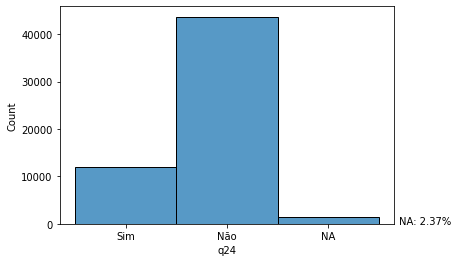

In [ ]:
q24 = data_df['q24'].copy().fillna(3)
data_label = {1: 'Sim', 2: 'Não', 3: 'NA'}
q24 = q24.map(data_label)
ax = sns.histplot(q24)
ax.text(2.7, 2, f'NA: {round(100*sum(data_df["q24"].isna())/len(data_df), 2)}%')
plt.show()

Como observado acima, há uma proporção maior da classe "Não", porém, acredito que essa característica pertence ao mundo real, logo, isso agrega à generalização do modelo. Outro ponto é que dados nulos correspondem à 2,37% dos exemplos, como é uma fatia pequena, esses exemplos serão removidos.

In [ ]:
data_df = data_df.dropna(subset = ['q24']).reset_index().drop(['index'], axis=1)
data_df['q24'].unique()

array([1., 2.])

Além do atributo `q24`, os demais também possuem entradas nulas, o ideal seria trata-las individualmente, porém, para otimização do tempo, todas serão preenchidas a seguir com a classe majoritária. 

In [ ]:
for column in data_df.columns:
    if not column == 'q24':
        mode = data_df[column].mode()[0]
        data_df[column].fillna(mode, inplace=True)

## Transformação dos dados

Agora, podemos seguir a transformação dos atributos. Todos os atributos já são númericos, facilitando a transformação dos dados, porém, todos iniciam contagem a partir do "1" invéz de "0" e perguntas de Sim e Não foram mantidas como 1 e 2, respectivamente. Além disso, há casos de atributos categóricos ordinais bagunçados, então, uma série de funções instanciadas abaixo serão aplicadas ao dataset para transformação dos atributos.

In [ ]:
def transform_binary_columns(dataframe, columns):
    for column in columns:
        if 2.0 in dataframe[column].unique():
            new_values = [0 if value == 2.0 else 1 for value in dataframe[column]]
            dataframe[column] = new_values
    return dataframe

def transform_ordinal_columns(dataframe, columns):
    for column in columns:
        if 0 not in dataframe[column].unique():
            dataframe[column] = dataframe[column].transform(lambda value: int(value - 1))
    return dataframe

def binarize_categorical_columns(dataframe, columns):
    for column in columns:
        lb = LabelBinarizer()
        lb.fit(dataframe[column])
        new_values = lb.transform(dataframe[column])
        new_values_df = pd.DataFrame(new_values)
        new_values_df.columns = [f'{column}_{str(value).split(".")[0]}' for value in lb.classes_]
        dataframe = pd.concat([dataframe, new_values_df], axis=1).drop([column], axis=1)
    return dataframe

def transform_special_ordinal_columns(dataframe, columns):
    for column in columns:
        unique_values = dataframe[column].unique().tolist()
        unique_values.sort()
        first = unique_values[0]
        others = unique_values[1:]
        others = others[::-1]
        new_values = [first] + others
        relabel_dict = {old_value: int(new_value) for old_value, new_value in zip(unique_values, new_values)}
        dataframe[column] = dataframe[column].map(relabel_dict)
    return dataframe

---

### Atributos descartados:
Há atibutos não relevantes ou que viriam por atrapalhar a generalização do modelo. Abaixo segue uma breve explicação da mitivação da exclusão dessas colunas:

- `q19`: é um atributo muito desbalanceado, com 70% dos exemplos agrupados em uma classse e o resto dividido entre as demais. Além de corresponder à causa de uma lesão sofrida pelo participante, o que não agrega substancialmente à generalização do modelo.

- `q25` e `q26`: Correspondem, respectivamente, à "*Fez um plano de suicídio?*" e "*Tentativa de suicídio.*", ambas questões se relacionam diretamente ao problema central sobre tendÊncia ao pensamento suicida, o que dificultaria a generalização do modelo sobre os outros atributos.

- `q30`: O atributo foi removido pois 91,9% dos exemplos estão agrupados em uma única classe, tornando o atributo pouco relevante ara generalização.

In [ ]:
useless_columns = ['q19', 'q25', 'q26', 'q30']

data_df = data_df.drop(useless_columns, axis=1)

---

### Atributos binários:

In [ ]:
binary_columns = ['q2', 'q24', 'q44', 'q66', 'q67', 'q68']

data_df = transform_binary_columns(data_df, binary_columns)



---

### Atributos categóricos não ordinais:

In [ ]:
categorical_columns = ['q18', 'q37', 'q47', 'q48']

data_df = binarize_categorical_columns(data_df, categorical_columns)

---

### Atributos categóricos ordinais:

In [ ]:
ordinal_columns = ['q1', 'q3', 'q6', 'q10', 'q15',
                   'q16', 'q17', 'q22', 'q23', 'q27',
                   'q29', 'q31', 'q32', 'q35', 'q36', 
                   'q38', 'q39', 'q41', 'q42', 'q43', 
                   'q46', 'q49', 'q50', 'q51', 'q52', 
                   'q53', 'q54', 'q55', 'q56', 'q57', 
                   'q58', 'q61', 'q62', 'q63']

data_df = transform_ordinal_columns(data_df, ordinal_columns)



---

### Atributos categóricos ordinais especiais:

In [ ]:
special_ordinal_columns = ['q28', 'q34', 'q40', 'q45']

data_df = transform_special_ordinal_columns(data_df, special_ordinal_columns)

---

### Tratamento especial atributo q33:

O atributo possui categorias divididas entre “Nenhum”, “Pai ou guardião”, “Mãe ou guardiã”, “Os dois” e “Não sei”, para simplificação dos dados, as classes “Pai ou guardião” e “Mãe ou guardiã” serão agrupadas em uma única classe “Pai/Guardião ou Mãe/Guardiã”.

In [ ]:
data_df['q33'] = data_df['q33'].apply(lambda x: x - 1 if x >= 3 else x)
data_df = binarize_categorical_columns(data_df, ['q33'])

---

### Padronização dos dados 

In [ ]:
y = data_df['q24']
X = data_df.drop(['q24'], axis=1)

ss = StandardScaler()
new_values = ss.fit_transform(X)
new_values_df = pd.DataFrame(new_values)
new_values_df.columns = X.columns

data_df = pd.concat([y, new_values_df], axis=1)

---

### Visualização dos dados transformados:

In [ ]:
data_df.head()

,q24,q1,q2,q3,q4,q5,q6,q10,q15,q16,q17,q22,q23,q27,q28,q29,q31,q32,q34,q35,q36,q38,q39,q40,q41,q42,q43,q44,q45,q46,q49,q50,q51,q52,q53,q54,q55,q56,q57,q58,q61,q62,q63,q66,q67,q68,q33_1,q33_2,q33_3,q33_4,q18_1,q18_2,q18_3,q18_4,q18_5,q18_6,q18_7,q18_8,q37_1,q37_2,q37_3,q37_4,q37_5,q37_6,q37_7,q47_1,q47_2,q47_3,q48_1,q48_2,q48_3,q48_4
0,1,-1.404354,-0.951660,-0.822009,-0.341102,-0.011165,0.722481,-0.549264,-0.330885,-0.405095,-0.513723,2.250050,2.513556,-0.583159,2.600614,4.189467,2.514529,1.703890,1.957162,3.482920,1.674510,-0.649130,5.141666,-0.380805,-0.339679,-0.266606,-0.131817,1.202517,2.615112,2.953849,1.642129,1.258124,-0.345366,2.139845,3.866711,-1.918971,-1.096169,1.258969,1.070513,-0.783117,-1.147324,-1.427522,1.605918,1.948103,1.920009,-0.521026,-1.341018,1.785560,-0.305374,-0.185578,0.579260,-0.258486,-0.122996,-0.137486,-0.035241,-0.075464,-0.029692,-0.415745,-0.951728,-0.566389,5.940288,-0.387641,-0.257931,-0.05023,-0.249828,-1.321303,-0.626228,3.334971,-1.325519,-0.52866,-0.331907,4.604120
1,0,-1.404354,-0.951660,-0.822009,-0.341102,-0.011165,-0.597870,-0.549264,-0.330885,-0.405095,-0.513723,-1.116522,-1.175953,0.569197,-0.745956,-0.389541,-0.608264,-0.319737,-1.588679,-0.772189,-0.882673,-0.649130,-0.337691,-0.380805,-0.339679,-0.266606,-0.131817,-0.831589,-0.695445,-0.574166,0.801793,-0.439064,-1.483722,-0.548229,-0.524511,-0.244970,0.316283,1.258969,1.070513,-0.783117,-0.569591,-0.206672,-1.088696,-0.513320,-0.520831,-0.521026,0.745702,-0.560048,-0.305374,-0.185578,0.579260,-0.258486,-0.122996,-0.137486,-0.035241,-0.075464,-0.029692,-0.415745,1.050720,-0.566389,-0.168342,-0.387641,-0.257931,-0.05023,-0.249828,0.756829,-0.626228,-0.299853,0.754421,-0.52866,-0.331907,-0.217197
2,0,0.805733,1.050796,-0.822009,1.287714,0.842714,-0.597870,1.529177,-0.330885,1.273838,-0.513723,-1.116522,0.668801,0.569197,2.600614,-0.389541,1.473598,-0.319737,1.957162,-0.063004,0.395919,0.506643,-0.337691,-0.380805,-0.339679,-0.266606,-0.131817,1.202517,2.615112,0.013836,0.381624,-1.117939,1.362167,0.123790,-0.524511,-0.244970,-1.096169,1.258969,1.070513,-0.783117,0.585875,-1.427522,1.066995,-0.513320,-0.520831,-0.521026,0.745702,-0.560048,-0.305374,-0.185578,0.579260,-0.258486,-0.122996,-0.137486,-0.035241,-0.075464,-0.029692,-0.415745,-0.951728,-0.566389,5.940288,-0.387641,-0.257931,-0.05023,-0.249828,-1.321303,1.596862,-0.299853,-1.325519,-0.52866,-0.331907,4.604120
3,0,-1.404354,-0.951660,-0.822009,-0.341102,-0.011165,-0.597870,-0.549264,-0.330885,-0.405095,-0.513723,-0.274879,0.668801,0.569197,-0.745956,-0.389541,-0.608264,-0.994279,-1.588679,-0.772189,-0.882673,-0.649130,-0.337691,-0.380805,-0.339679,-0.266606,-0.131817,-0.831589,-0.695445,-0.574166,-0.458712,-0.439064,-0.345366,-1.220247,-0.524511,0.592030,1.022509,0.593917,1.070513,-0.783117,-1.147324,-0.817097,-0.549773,-0.513320,-0.520831,-0.521026,0.745702,-0.560048,-0.305374,-0.185578,0.579260,-0.258486,-0.122996,-0.137486,-0.035241,-0.075464,-0.029692,-0.415745,1.050720,-0.566389,-0.168342,-0.387641,-0.257931,-0.05023,-0.249828,0.756829,-0.626228,-0.299853,0.754421,-0.52866,-0.331907,-0.217197
4,0,-1.404354,1.050796,-0.822009,1.162420,-1.035821,-0.597870,0.836363,-0.330885,0.434371,0.437937,-1.116522,-0.253576,0.569197,-0.745956,-0.389541,-0.608264,-0.994279,0.437516,-0.063004,-0.030278,-0.649130,-0.337691,-0.380805,-0.339679,-0.266606,-0.131817,-0.831589,-0.695445,-0.574166,-0.458712,-0.439064,-0.345366,-1.220247,-0.524511,0.592030,1.728735,1.258969,1.070513,-0.783117,1.741341,-0.817097,-0.010851,-0.513320,-0.520831,-0.521026,0.745702,-0.560048,-0.305374,-0.185578,-1.726341,3.868683,-0.122996,-0.137486,-0.035241,-0.075464,-0.029692,-0.415745,-0.951728,-0.566389,-0.168342,-0.387641,-0.257931,-0.05023,4.002753,0.756829,-0.626228,-0.299853,0.754421,-0.52866,-0.331907,-0.217197


In [ ]:
print("Total de atributos:", data_df.shape[1], "\nTotal de exemplos: ", data_df.shape[0])

Total de atributos: 72 
Total de exemplos:  55628


## Redução de dimensão

Com a grande quantidade de colunas geradas na etapa de transformação dos dados e mostrado acima, se torna necessária a redução dessa dimensionalidade, visando otimização de performance do treinamento dos modelos.

Vamos primeiro realizar uma análise dos principais componentes entre os atributos. Para isso será utilizado o modulo `PCA` da bibliotaca `scikit learn` e será analisado a explicabilidade dos primeiros 15 atributos mais importantes.

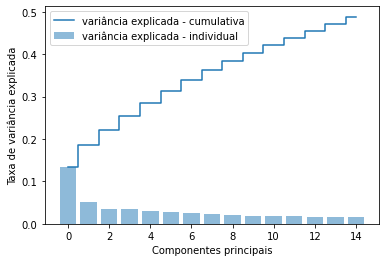

In [ ]:
X = data_df.drop(['q24'], axis=1)
y = data_df['q24']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10, stratify=y)

pca = PCA(n_components=None)

pca.fit(X_train)

pca_ratio = pca.explained_variance_ratio_

pca_ratio_slice = pca_ratio[:15]
cum_ratio = np.cumsum(pca_ratio_slice)

plt.bar(range(len(pca_ratio_slice)), pca_ratio_slice, alpha=0.5, align='center', label='variância explicada - individual')
plt.step(range(len(cum_ratio)), cum_ratio, where='mid', label='variância explicada - cumulativa')

plt.ylabel('Taxa de variância explicada')
plt.xlabel('Componentes principais')
plt.legend(loc='best')
plt.show()

Com o gráfico acima é possivel notar que a técnica `PCA` não se saiu bem neste dataset, pois, nenhum pequeno grupo de atributos responde à uma boa taxa de explicabilidade dos dados.

A partir dessa conclusão poderíamos partir para utilização da técnica `LDA`, porém, essa técnica seleciona `c - 1` atributos, onde `c` é o número de classes. Como há somente duas classes essa técnica é inútil para o problema, então, para utilizar uma técnica supervisionada pode-se treinar uma RandomForest para analisar a importância dos atributos, como a seguir.

In [ ]:
rf = RandomForestClassifier(n_estimators=1000,
                            random_state=10,
                            n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=10)

Com a floresta treinada podemos olhar para importância de cada atributos, como segue.

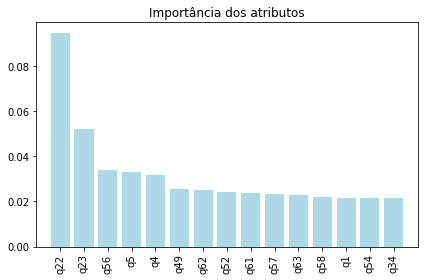

In [ ]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]
indices_slice = indices[:15]

plt.title('Importância dos atributos')
plt.bar(range(15), importances[indices_slice], color='lightblue', align='center')
plt.xticks(range(15), X_train.columns[indices_slice], rotation=90)
plt.xlim([-1, 15])
plt.tight_layout()
plt.show()

Agora, com o grau de importância dos atributos é possível notar que o padrão de pouca variação de explicabilidade dos atributos vista na aplicação do `PCA` continua. Então, serão utilizadas os atributos que correspondem à até 70% de importância.

In [ ]:
selected_indices = [idx for idx, cumsum in zip(indices, np.cumsum(importances[indices])) if cumsum <= 0.7]
selected_columns = X_train.columns[selected_indices].tolist()

print('Atributos selecionados:', selected_columns)

Atributos selecionados: ['q22', 'q23', 'q56', 'q5', 'q4', 'q49', 'q62', 'q52', 'q61', 'q57', 'q63', 'q58', 'q1', 'q54', 'q34', 'q3', 'q28', 'q50', 'q15', 'q55', 'q51', 'q32', 'q68', 'q2', 'q36', 'q10']


Com a lista de atributos selecionados é possível finaliar a transformação do dataset.

In [ ]:
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

## Treinamento e avaliação dos modelos

O dicionário abaixo será utilizado para agrupar os modelos treinados e suas respectivas métricas e a variável `n_folds` corresponde a quantidade de paginações que serão executadas no treinamento e teste de cada modelo.

In [ ]:
trained_models = {}
n_folds = 5

---

### Treinamento KNN

In [ ]:
knn = KNeighborsClassifier()

knn_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

knn_gscv = GridSearchCV(estimator=knn,
                        param_grid=knn_grid,
                        scoring='f1',
                        cv=n_folds)

knn_gscv.fit(X_train, y_train)

trained_models['KNN'] = {'score': knn_gscv.best_score_,
                         'estimator': knn_gscv}
print(f"KNN F1 Score: {trained_models['KNN']['score']}")

KNN F1 Score: 0.40966786840297936




---

### Treinamento SVM

In [ ]:
svc = SVC()

svm_grid = {
    'C': [.5, 1.0, 1.5],
    'kernel': ['poly', 'rbf']
}

svm_gscv = GridSearchCV(estimator=svc,
                        param_grid=svm_grid,
                        scoring='f1',
                        cv=n_folds)

svm_gscv.fit(X_train, y_train)

trained_models['SVM'] = {'score': svm_gscv.best_score_,
                         'estimator': svm_gscv}
print(f"SVM F1 Score: {trained_models['SVM']['score']}")

SVM F1 Score: 0.44033881271641473




---

### Treinamento XGBoost

In [ ]:
xgb = XGBClassifier()

xgb_grid = {
    'objective':['binary:logistic', 'binary:hinge'],
    'learning_rate': [.05, .3],
    'max_depth': [5, 10],
    'subsample': [0.5, 1],
    'colsample_bytree': [0.5, 1],
    'n_estimators': [100, 500],
    'use_label_encoder': [False],
    'verbosity': [0]
}

xgb_gscv = GridSearchCV(estimator=xgb,
                        param_grid=xgb_grid,
                        scoring='f1',
                        cv=n_folds) 

xgb_gscv.fit(X_train, y_train)

trained_models['XGB'] = {'score': xgb_gscv.best_score_,
                         'estimator': xgb_gscv}
print(f"XGB F1 Score: {trained_models['XGB']['score']}")

XGB F1 Score: 0.5066599292159832




---

### Avaliação

In [ ]:
for model in trained_models.keys():
    estimator = trained_models[model]['estimator']
    test_score = round(trained_models[model]["score"], 2)
    y_pred = estimator.predict(X_test)
    evaluation_score = round(f1_score(y_test, y_pred), 2)
    print(f'{model}: Test: {test_score} - True: {evaluation_score}')

KNN: Test: 0.41 - True: 0.41
SVM: Test: 0.44 - True: 0.44
XGB: Test: 0.51 - True: 0.5


Como está sendo utilizado a métrica F1, o melhor resultado possível seria `1.0`, porém, com a célula acima, é possível notar que os modelos não obtiveram um resultado satisfatório.


## Conclusão
Com o baixo desempenho dos modelos explicitado acima pode-se considerar duas possibilidades. Primeira, que os dados selecionados não foram bem trabalhados, ou seja, não foi realizada uma boa engenharia de atributos. E, segunda, os dados não possuem uma boa separabilidade, isso é, as classes não estão bem definidas, dificultado assim a decibilidade dos modelos treinados.

Infelizmente não houve tempo de testar mais modelos e outras técnicas de transformação dos dados, porém, não vejo muitas esperanças. Atribuo o fato do baixo desempenho dos modelos à baixa separabilidade das classes utilizadas. Pois, como visto na seção de redução de dimensionalidade, não haviam atributos explicativos o suficiente para optar pela técnica PCA.